In [5]:
# Import necessary libraries
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os


In [6]:
# Define function to parse logs
def parse_logs(log_file):
    results = []
    with open(log_file, 'r') as file:
        for line in file:
            
            # Match Communication Round
            comm_round_match = re.search(r"in comm round:(\d+)", line)
            if comm_round_match:
                comm_round = int(comm_round_match.group(1))
                results.append({"comm_round": comm_round})

            # Match Epoch Loss
            epoch_loss_match = re.search(r"Epoch: (\d+) Loss: (-?\d+\.\d+)", line)
            if epoch_loss_match:
                epoch = int(epoch_loss_match.group(1))
                loss = float(epoch_loss_match.group(2))
                results.append({"epoch": epoch, "loss": loss})

            # Match Global Accuracy Top1
            accuracy_top1_match = re.search(r">> Global Model Test accuracy Top1: (\d+\.\d+)", line)
            if accuracy_top1_match:
                accuracy_top1 = float(accuracy_top1_match.group(1))
                results.append({"epoch": -1, "accuracy_top1": accuracy_top1})

            # Match Global Accuracy Top5
            accuracy_top5_match = re.search(r">> Global Model Test accuracy Top5: (\d+\.\d+)", line)
            if accuracy_top5_match:
                accuracy_top5 = float(accuracy_top5_match.group(1))
                results.append({"epoch": -1, "accuracy_top5": accuracy_top5})
    
    return pd.DataFrame(results)


In [7]:
# Function to extract metadata from log filename
def extract_metadata(filename):
    match = re.match(
        r"(?P<dataset>[^-]+)-(?P<portion>[^-]+)-(?P<method>[^-]+)-(?P<batch_size>[^-]+)-(?P<n_parties>[^-]+)-(?P<temperature>[^-]+)-(?P<tt>[^-]+)-(?P<ts>[^-]+)-(?P<epochs>[^_]+)_log-(?P<timestamp>\d{4}-\d{2}-\d{2}-\d{2}\d{2}-\d{2})",
        filename
    )
    if match:
        return match.groupdict()
    return {}


In [8]:
# Load data from all log files in the logs folder
log_folder = "./logs"
log_files = [os.path.join(log_folder, f) for f in os.listdir(log_folder) if f.endswith(".log")]

# Process and combine data from all log files
dataframes = {}
i = 0
for log_file in log_files:
  filename = os.path.basename(log_file)
  metadata = extract_metadata(filename)
  df = parse_logs(log_file)
  for key, value in metadata.items():
    df[key] = value
  dataframes[filename] = df
  if i == 1:
    break
  i += 1
  

In [9]:
# Combine all datasets for unified analysis
combined_df = pd.concat(dataframes.values(), ignore_index=True)

# Add metadata columns with default values if they do not exist
metadata_columns = ["portion", "batch_size", "n_parties", "temperature", "tt", "ts", "epochs"]
# Convert metadata columns to appropriate data types
for col in metadata_columns:
    combined_df[col] = combined_df[col].astype(float) if col in ["portion", "temperature", "tt", "ts"] else combined_df[col].astype(int)


In [10]:
combined_df.head()

,comm_round,epoch,loss,accuracy_top1,accuracy_top5,dataset,portion,method,batch_size,n_parties,temperature,tt,ts,epochs,timestamp
0,0.0,NaN,NaN,NaN,NaN,cifar10,0.1,simsiam,512,10,0.1,0.1,0.1,10,2025-01-28-1352-15
1,NaN,0.0,-0.685236,NaN,NaN,cifar10,0.1,simsiam,512,10,0.1,0.1,0.1,10,2025-01-28-1352-15
2,NaN,1.0,-3.878116,NaN,NaN,cifar10,0.1,simsiam,512,10,0.1,0.1,0.1,10,2025-01-28-1352-15
3,NaN,2.0,-7.108733,NaN,NaN,cifar10,0.1,simsiam,512,10,0.1,0.1,0.1,10,2025-01-28-1352-15
4,NaN,3.0,-8.830254,NaN,NaN,cifar10,0.1,simsiam,512,10,0.1,0.1,0.1,10,2025-01-28-1352-15


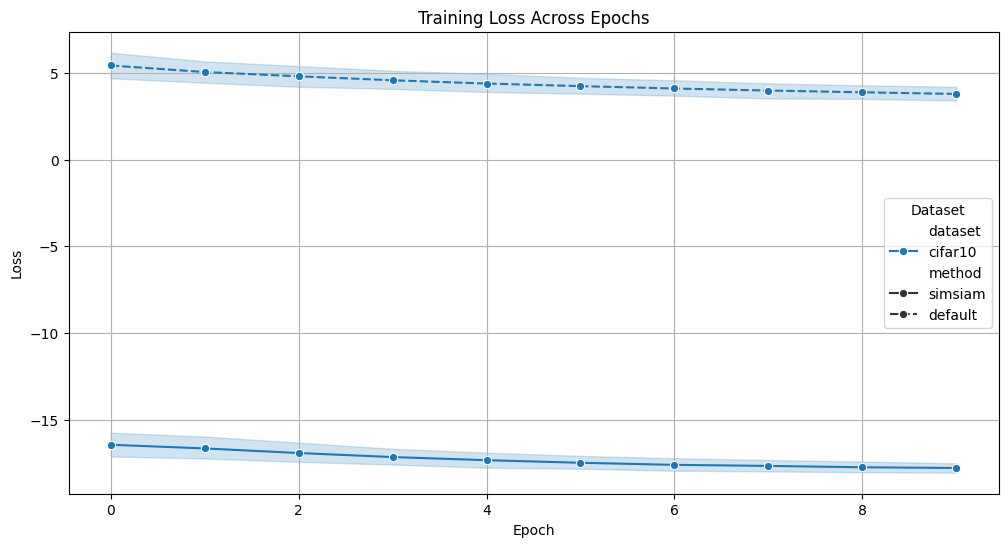

In [11]:
# Plot Losses with Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=combined_df[combined_df["epoch"] >= 0], 
    x="epoch", 
    y="loss", 
    hue="dataset",
    style="method",
    marker="o"
)
plt.title("Training Loss Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Dataset")
plt.grid()
plt.show()

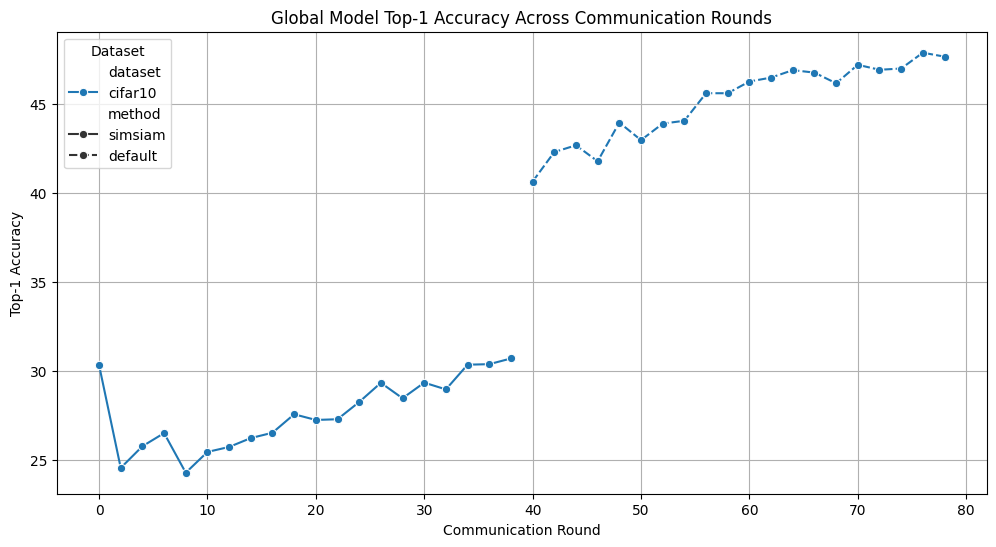

In [12]:
# Plot Global Accuracy Top1 with Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=combined_df[combined_df["epoch"] == -1],
    x=combined_df[combined_df["epoch"] == -1].groupby("dataset").cumcount(),
    y="accuracy_top1",
    hue="dataset",
    style="method",
    marker="o"
)
plt.title("Global Model Top-1 Accuracy Across Communication Rounds")
plt.xlabel("Communication Round")
plt.ylabel("Top-1 Accuracy")
plt.legend(title="Dataset")
plt.grid()
plt.show()

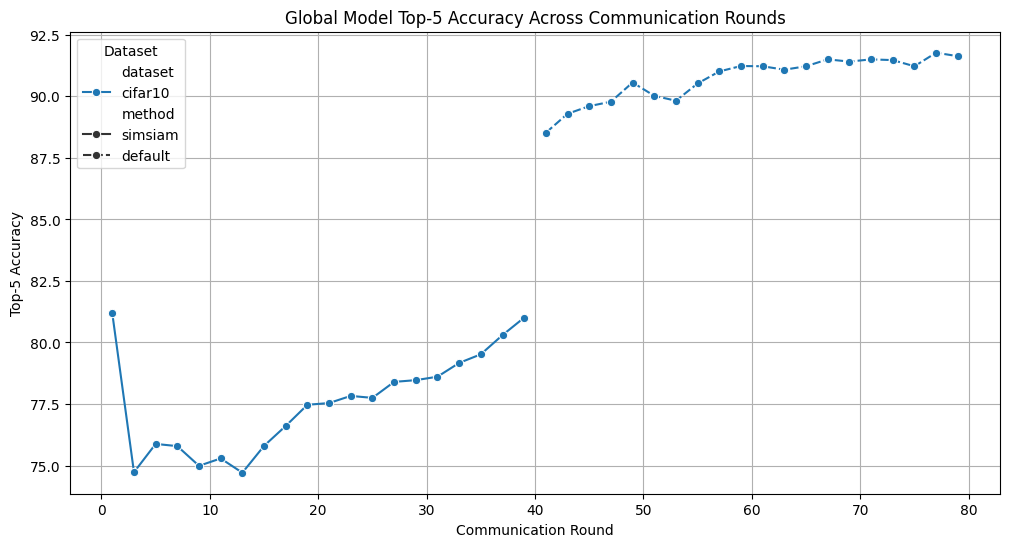

In [13]:
# Plot Global Accuracy Top5 with Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=combined_df[combined_df["epoch"] == -1],
    x=combined_df[combined_df["epoch"] == -1].groupby("dataset").cumcount(),
    y="accuracy_top5",
    hue="dataset",
    style="method",
    marker="o"
)
plt.title("Global Model Top-5 Accuracy Across Communication Rounds")
plt.xlabel("Communication Round")
plt.ylabel("Top-5 Accuracy")
plt.legend(title="Dataset")
plt.grid()
plt.show()